In [1]:
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# import layers we will use
from tensorflow.keras import layers
#.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate, Dropout
from tensorflow.keras import Model

# import callbacks we will use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Load the TensorBoard notebook extension
%load_ext tensorboard

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
plt.rcParams.update({'font.size': 18})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

### Python version: 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) 
[GCC 7.5.0]
### Numpy version: 1.19.4
### Scikit-learn version: 0.23.2
### Tensorflow version: 2.3.1
------------


In [2]:
# Get directories for different sets of images
data_path = '/home/smarkelon/aml/ships/data/'
path = '/home/smarkelon/aml/ships/'
train_path = path + 'train'
test_path = path + 'test'
validation_path = path + 'validation'

try:
    os.mkdir(train_path)
except:
    pass

try:
    os.mkdir(test_path)
except:
    pass

"""
try:
    os.mkdir(validation_path)
except:
    pass
"""

data_dirs = [train_path,test_path]

In [3]:
# Create smaller training, testing, and validation sets from original training data
import shutil
import random

# clean out directories first just in case
for d in data_dirs:
    del_files = os.listdir(d)
    for dlf in del_files:
        os.remove(d+"/"+dlf)

train_size = 10000
test_size = 2000
validation_size = 0

files = os.listdir(data_path)
random.shuffle(files)

# Create training set
for f in files[:train_size]:
    shutil.copy(data_path + f, train_path)

# Create test set
for f in files[train_size:train_size+test_size]:
    shutil.copy(data_path + f, test_path)

"""
# Create validation set
for f in files[train_size+test_size:train_size+test_size+validation_size]:
    shutil.copy(path + f, validation_path)
"""

'\n# Create validation set\nfor f in files[train_size+test_size:train_size+test_size+validation_size]:\n    shutil.copy(path + f, validation_path)\n'

In [4]:
# Look at data
train_names = os.listdir(train_path)
print(train_names[:10])

['c44773b08.jpg', '4de3cb292.jpg', 'fd0b2eb0f.jpg', 'e384f0a56.jpg', '64b645b0f.jpg', 'e84e82baf.jpg', '6f612d1f8.jpg', 'fef8daf58.jpg', '8cbb2970b.jpg', 'ef65e34e7.jpg']


In [5]:
print('total training images:', len(os.listdir(train_path)))

total training images: 10000


In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

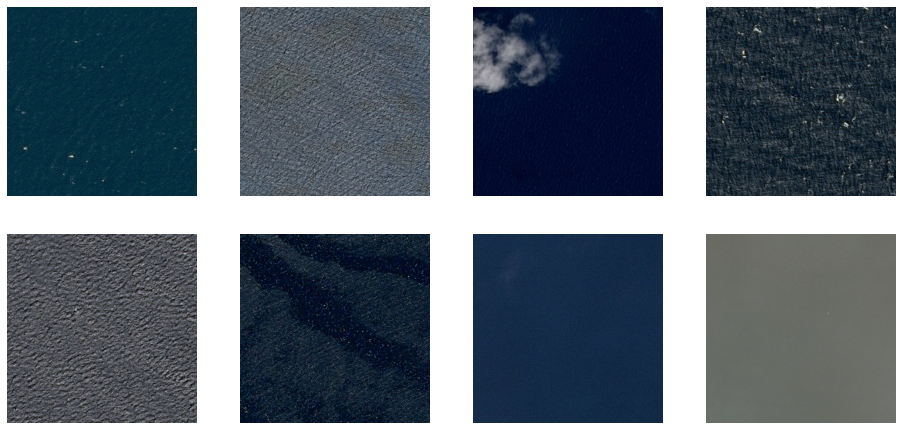

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_set = [os.path.join(train_path, fname) 
                for fname in train_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_set):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
# Get labels from CSV file
df=pd.read_csv('/home/smarkelon/aml/ships/ship_data_bc_proc.csv',dtype=str)
df

,ImageId,ShipPresent
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)

# Generate training dataset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='ImageId',
    y_col='ShipPresent',
    #subset='training',
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

#Generate testing dataset
test_generator = test_datagen.flow_from_dataframe(
     dataframe=df,
     directory=test_path,
     x_col='ImageId',
     y_col='ShipPresent',
     #subset='testing',
     target_size=(150, 150),  # All images will be resized to 150x150
     batch_size=20,
     # Since we use binary_crossentropy loss, we need binary labels
     class_mode='binary')

"""
# Generate validation dataset
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df,
    directory=validation_path,
    x_col='ImageId',
    y_col='ShipPresent',
    #subset='validation',
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')
"""

/apps/tensorflow/2.3.1/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 182556 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  warnings.warn(


Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


/apps/tensorflow/2.3.1/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 190556 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  warnings.warn(


"\n# Generate validation dataset\nval_generator = val_datagen.flow_from_dataframe(\n    dataframe=df,\n    directory=validation_path,\n    x_col='ImageId',\n    y_col='ShipPresent',\n    #subset='validation',\n    target_size=(150, 150),  # All images will be resized to 150x150\n    batch_size=20,\n    # Since we use binary_crossentropy loss, we need binary labels\n    class_mode='binary')\n"

In [10]:
# get weights for inception v3 model trained on imagenet
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /home/smarkelon/aml/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-15 18:42:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.177.128, 173.194.219.128, 64.233.185.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.177.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/home/smarkelon/aml/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

100%[======================================>] 87,910,968  46.1MB/s   in 1.8s   

2021-04-15 18:42:57 (46.1 MB/s) - ‘/home/smarkelon/aml/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/home/smarkelon/aml/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# exclude top classificaltion layers as we only want feature extraction
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

# make model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [18]:
# feature extraction layer is mixed7
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

# put fully connected classifier layer on top of last_output of feature extraction layers
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

last layer output shape: (None, 7, 7, 768)


In [19]:
import math

# Set up model checkpoint to save best model
best_model_file3 = 'mymodel3.h5'
checkpoint_cb = ModelCheckpoint(best_model_file3, monitor='val_acc', save_best_only=True, mode='max')


train_size = 10000
test_size = 2000
batch_size = 20

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

spe = compute_steps_per_epoch(train_size)
vs = compute_steps_per_epoch(test_size)

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=spe,
      epochs=5,
      validation_data=test_generator,
      validation_steps=vs,
      verbose=2, callbacks=[checkpoint_cb])

Epoch 1/5
500/500 - 96s - loss: 0.4925 - acc: 0.8299 - val_loss: 0.2803 - val_acc: 0.8960
Epoch 2/5
500/500 - 95s - loss: 0.3363 - acc: 0.8779 - val_loss: 0.2904 - val_acc: 0.8825
Epoch 3/5
500/500 - 95s - loss: 0.2987 - acc: 0.8939 - val_loss: 0.2849 - val_acc: 0.9020
Epoch 4/5
500/500 - 96s - loss: 0.2630 - acc: 0.9071 - val_loss: 0.3104 - val_acc: 0.9035
Epoch 5/5
500/500 - 95s - loss: 0.2369 - acc: 0.9126 - val_loss: 0.2896 - val_acc: 0.9050


In [22]:
# fine tunings
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [23]:
# train model with finetuneings

import math
# Set up model checkpoint to save best model
best_model_file4 = 'mymodel4.h5'
checkpoint_cb = ModelCheckpoint(best_model_file4, monitor='val_acc', save_best_only=True, mode='max')

train_size = 10000
test_size = 2000
batch_size = 20

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

spe = compute_steps_per_epoch(train_size)
vs = compute_steps_per_epoch(test_size)

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=spe,
      epochs=10,
      validation_data=test_generator,
      validation_steps=vs,
      verbose=2, callbacks=[checkpoint_cb])

Epoch 1/10
500/500 - 96s - loss: 0.1926 - acc: 0.9313 - val_loss: 0.2475 - val_acc: 0.9075
Epoch 2/10
500/500 - 96s - loss: 0.1905 - acc: 0.9316 - val_loss: 0.2464 - val_acc: 0.9090
Epoch 3/10
500/500 - 95s - loss: 0.1925 - acc: 0.9320 - val_loss: 0.2458 - val_acc: 0.9085
Epoch 4/10
500/500 - 94s - loss: 0.1906 - acc: 0.9329 - val_loss: 0.2449 - val_acc: 0.9075
Epoch 5/10
500/500 - 97s - loss: 0.1881 - acc: 0.9346 - val_loss: 0.2441 - val_acc: 0.9105
Epoch 6/10
500/500 - 94s - loss: 0.1826 - acc: 0.9347 - val_loss: 0.2437 - val_acc: 0.9090
Epoch 7/10
500/500 - 94s - loss: 0.1830 - acc: 0.9352 - val_loss: 0.2432 - val_acc: 0.9100
Epoch 8/10
500/500 - 94s - loss: 0.1795 - acc: 0.9356 - val_loss: 0.2428 - val_acc: 0.9095
Epoch 9/10
500/500 - 95s - loss: 0.1798 - acc: 0.9368 - val_loss: 0.2429 - val_acc: 0.9095
Epoch 10/10
500/500 - 94s - loss: 0.1770 - acc: 0.9361 - val_loss: 0.2429 - val_acc: 0.9080


Text(0.5, 1.0, 'Training and validation loss')

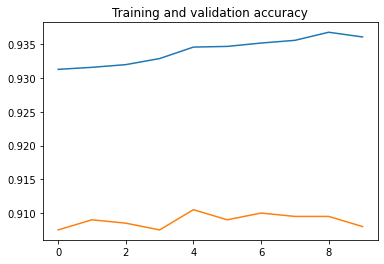

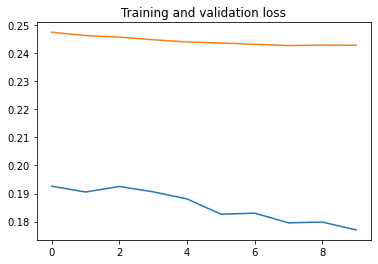

In [24]:
# plot training and validation loss and accuracy

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')